**<font  size=6>回測框架</font>**

In [1]:
import backtrader as bt
import backtrader.indicator as btind
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import argparse
import datetime
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
from scipy.stats import rankdata
import matplotlib.pyplot as plt
#binance 用pip python-binance裝
import binance
import gradient_free_optimizers as gfo

#pyfolio 用 pip install git+https://github.com/quantopian/pyfolio 裝，不然會報錯
import pyfolio as pf

**<font  size=5>導入數據</font>**

In [2]:
##########################################################
#下載歷史資料
##########################################################
client = binance.Client()      #先將API實例化方便取用

##########################################################
#撰寫幣安爬蟲API
##########################################################
def data_download(symbol, symbol_class, interval, start_str) :

    if symbol_class == 'spot' :
        klines = client.get_historical_klines(symbol, interval, start_str)
    if symbol_class == 'future' :
        klines = client.futures_historical_klines(symbol, interval, start_str)
    data = pd.DataFrame(klines)
    data.columns = ['open_time', 'open', 'high', 'low', 'close',
    'volume', 'close_time', 'qav', 'num_trades',
    'taker_base_vol', 'taker_base_vol', 'ignore']    
    data.index = [datetime.datetime.fromtimestamp(x/1000.0) for x in data.close_time]
    data.index = data.index + datetime.timedelta(seconds = 0.001)
    data.reset_index(inplace=True)
    data.set_index('index',inplace=True)
    data = data[['open','high','low','close','volume']]
    data['open'] = data['open'].astype(float)
    data['high'] = data['high'].astype(float)
    data['low'] = data['low'].astype(float)
    data['close'] = data['close'].astype(float)
    data['volume'] = data['volume'].astype(float)
    data["openinterest"] = 0
    return data    

    
##########################################################
#下載歷史資料 data1=期貨 , data2=現貨
##########################################################
data1 = data_download('BTCUSDT','future','30m','2021-01-01')
data2 = data_download('BTCUSDT','spot','30m','2021-01-01')

#用pd函數intersection取出交集，在將交集放入原始資料，使兩者長度相等
idx = data1.index.intersection(data2.index)
data1 = data1.loc[idx]
data2 = data2.loc[idx]

**<font  size=4> 整理成引擎能接受的格式</font>**

In [3]:
params = dict(
            fromdate = datetime.datetime(2021,1,1), # 回測開始時間
            todate = datetime.datetime(2022,12,31),  # 回測結束時間
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和時間格式
            tmformat=('%H:%M:%S'), # 時間格式
            datetime=0, # 下面幾行是導入的數據，要和傳入的數據列進行一一對應，以這個參數為準
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=6)

            
##########################################################
# 建立datafeed，這裡是從內存的pandasDataFrame，可以有別的來源，詳見bt.feeds
##########################################################
datafeed1 = bt.feeds.PandasDirectData(dataname = data1, **params)
datafeed2 = bt.feeds.PandasDirectData(dataname = data2, **params)

In [4]:
##########################################################
#建立優化datafeed參數
##########################################################
params_opt = dict(
            fromdate = datetime.datetime(2021,1,1), # 回測開始時間
            todate = datetime.datetime(2022,6,30),  # 回測結束時間
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和時間格式
            tmformat=('%H:%M:%S'), # 時間格式
            datetime=0, # 下面幾行是導入的數據，要和傳入的數據列進行一一對應，以這個參數為準
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=6)

# 建立優化datafeed，這裡是從內存的pandasDataFrame，可以有別的來源，詳見bt.feeds
datafeed1_opt = bt.feeds.PandasDirectData(dataname = data1, **params_opt)
datafeed2_opt = bt.feeds.PandasDirectData(dataname = data2, **params_opt)

**<font  size=5>定義買入比例</font>**

In [5]:
class percent(bt.Sizer):
    params = (
        ('retint',True),
    )

    def __init__(self):
        pass
    def _getsizing(self, comminfo, cash, data, isbuy):
        position = self.broker.getposition(data).size
        if position == 0:
            size = cash/ (data.close[0])
            size = int(size)
        else:
            size = position
            
        if self.p.retint:
            size = int(size)
        return size

**<font  size=5>定義策略類</font>**

首先說明，這個基於Backtrader框架集成參數優化與可視化的回測方法，策略代碼要編的好必須熟悉基礎的backtrader引擎邏輯，以下幾點說明，詳見backtrader包:
- 策略類中參數必須定義成類變量params -> tuple，其中包含參數tuple，格式要跟我寫的一樣。
- 指標定義成實例變量(__init__方法中)
- 框架中self.datas[i]為你餵入的第i個資產的數據(我們這邊有兩個資產，一個當指標)，self.datas[i].close[0]為你餵入的第i個資產的數據現在這個k線的close價，self.datas[i].close[-1]為上一根的close價，self.datas[i].close[1]為 下一根的close價
- 我所用到的指標計算函數除了我自己定義的，都可以在backtrader.ind找到使用方法

In [6]:
##########################################################
#示範編寫參數方法，這裡只實現一個，其他我直接寫在策略類裡，也可以拉出來實現(我懶)
##########################################################
class difInd(bt.Indicator):
    lines = ('dif',)

    def next(self):
        self.lines.dif[0] = self.datas[0].close[0] - self.datas[1].close[0]


##########################################################
#策略類
##########################################################
class TestStrategy(bt.Strategy):
    #參數，之後優化可能會用到，這邊是默認
    params = (
        ('rolling_window', 130),
        ('tp_ratio', 20),
        ('sl_ratio', 6),
        ('longout', 80),
        ('shortout', 120),
        ('printout', False),#參數，是否打印行情(next中)
    )

    def log(self, txt):
        ''' Logging function for this strategy'''
        print('%s' % (txt))

    #定義會用到的指標或變量
    def __init__(self):
        # 保留對 data[0] 數據系列中“close”行的引用(為了方便)
        self.dataclose = self.datas[0].close

        #定義變量紀錄買賣價格
        self.buyprice = None
        self.sellprice = None

        #定義變量紀錄委託
        self.lmt_1 = None
        self.lmt_2 = None
        
        #定義各指標
        self.dif = difInd(self.datas[0],self.datas[1])
        self.spread_avg = (bt.ind.Highest(self.dif,period=self.params.rolling_window) - bt.ind.Lowest(self.dif,period=self.params.rolling_window))/2
        self.low = bt.ind.Lowest(self.datas[0].close,period = self.params.rolling_window)
        self.spot_hl = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) - self.low)/2
        self.spot_line = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) + self.low)/2
        self.upper_band = self.spot_line + 0.3*(self.spot_hl+self.spread_avg)
        self.lower_band = self.spot_line - 0.2*(self.spot_hl+self.spread_avg)
        self.lowout = bt.ind.Lowest(self.datas[0].low,period=self.params.longout)
        self.highout = bt.ind.Highest(self.datas[0].high,period =self.params.shortout)
        
        #定義變量紀錄倉位，注意!在每個策略中要有自己的倉位或信號紀錄，不要用backtrader框架中的self.position，不然在多個策略同引擎一起回測時會有問題(A策略開的倉被B策略平掉)
        self.sposition = 0
        
        #定義是否在買賣時點圖中畫出指標
        self.dif.plotinfo.plot = False
        self.low.plotinfo.plot = False
        self.datas[1].plotinfo.plot = False
        self.lowout.plotinfo.plot = True
        self.lowout.plotinfo.subplot = False
        self.highout.plotinfo.plot = True
        self.highout.plotinfo.subplot = False

    

    def start(self):
        #是否打印K線行情        
        # if self.p.printout:
        #     txtfields = list()
        #     txtfields.append('Len')
        #     txtfields.append('Datetime')
        #     txtfields.append('Open')
        #     txtfields.append('High')
        #     txtfields.append('Low')
        #     txtfields.append('Close')
        #     txtfields.append('Volume')
        #     txtfields.append('OpenInterest')
        #     print(','.join(txtfields))
        pass

    #如果有委託產生，就會執行一次
    def notify_order(self, order):
        type = "Buy" if order.isbuy() else "Sell"
        #如果是提交或是允許，不做任何事(也會有order.status == order.Margin的狀況，如果錢不夠執行你的委託)，詳見backtrader        
        if order.status in [order.Submitted,order.Accepted]:
            return

        #如果是委託成交，執行下面的指令
        if order.status in [order.Completed]:
            if self.p.printout:
                print('---------------------------------------------------------------------------------------------------------------------------------')
                self.log(
                f"{order.data.datetime.datetime(0).isoformat()}\t"
                f"{order.data._name:<6} Order: {order.ref:3d}\tType: {type:<5}\tStatus"
                f" {order.getstatusname():<8} \t"
                f"Size: {order.created.size:9.4f} \t Create Price: {order.created.price:9.4f} \t"
                f"Position: {self.getposition(order.data).size}\t\t"
                f"Exectype: {('Stop' if order.exectype == 3 else 'Limit')}\t"
                )

        
        
            #如果是買單成交
            if order.isbuy():
                #倉位+=1(初始是0)
                self.sposition +=1
                #記錄買單成交價
                self.buyprice = order.executed.price
                
                #如果倉位是1(也就是開倉)
                if self.sposition == 1:
                    #掛一個Limit的賣單(用self.close來寫或許比較好但我懶得改)，並記錄這個賣單
                    self.lmt_1 = self.close(exectype= bt.Order.Limit, price = self.buyprice*(1+0.01*self.params.tp_ratio))
                    #掛一個STOP的賣單(用self.close來寫或許比較好但我懶得改)，注意!後面調用oco方法指定上面我們紀錄的Limit賣單，這樣兩個委託(之後還會再綁一個)就會綁在一起，實現一個成交cancel其他委託的功能
                    self.sell(exectype = bt.Order.Stop, price = self.buyprice*(1-0.01*self.params.sl_ratio),oco = self.lmt_1)

            #同上，買變成賣
            elif order.issell():
                self.sposition -=1 
                self.sellprice = order.executed.price
                if self.sposition == -1:
                    self.lmt_2 = self.close(exectype=bt.Order.Limit, price = self.sellprice*(1-0.01*self.params.tp_ratio))
                    self.close(exectype=bt.Order.Stop, price= self.sellprice*(1+0.01*self.params.sl_ratio),oco = self.lmt_2)
                    
        
       


    #在這邊可寫可不寫，只是展示一下有這個功能
    def notify_trade(self, trade):
        #部位如果沒close不做任何事
        if not trade.isclosed:
            return


    #核心策略寫在這裡
    def next(self):
        
        # if self.p.printout:
        #     # 僅打印第一個數據...只是檢查是否正在運行
        #     txtfields = list()
        #     txtfields.append('%04d' % len(self))
        #     txtfields.append(self.data.datetime.datetime(0).isoformat())
        #     txtfields.append('%.2f' % self.datas[0].open[0])
        #     txtfields.append('%.2f' % self.datas[0].high[0])
        #     txtfields.append('%.2f' % self.datas[0].low[0])
        #     txtfields.append('%.2f' % self.datas[0].close[0])
        #     txtfields.append('%.2f' % self.datas[0].volume[0])
        #     txtfields.append('%.2f' % self.datas[0].openinterest[0])
        #     print(','.join(txtfields))



        # 檢查我們是否有部位
        #如果沒有
        if self.sposition ==0:
            #策略條件
            if (self.dataclose[-1] < self.upper_band[0]) & (self.dataclose[0] > self.upper_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                #開倉買入
                self.buy(exectype= bt.Order.Limit,price = self.dataclose[0],data = self.datas[0])

            #策略條件
            elif (self.dataclose[-1] > self.lower_band[0]) & (self.dataclose[0] < self.lower_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                #開倉賣出
                self.sell(exectype= bt.Order.Limit,price = self.dataclose[0],data = self.datas[0])


        #如果有多倉
        if self.sposition == 1:
            #策略條件
            if self.dataclose[0] <= self.lowout[0]:
                #賣出，oco綁定上面的lmt_1，三個綁在一起，一個成交其他取消
                self.close(oco = self.lmt_1)

        # 如果有空倉
        if self.sposition == -1:
            #策略條件
            if self.dataclose[0] >= self.highout[0]:
                #買入，oco綁定上面的lmt_2，三個綁在一起，一個成交其他取消
                self.close(oco = self.lmt_2)



In [7]:
##########################################################
#隨便寫一個策略測試多策略回測
##########################################################
class SmaCross(bt.Strategy):
    params = (
        ('sma1', 10),
        ('sma2', 30),
        ('printout', False),
    )
    def __init__(self):
        SMA1 = bt.ind.SMA(period = self.params.sma1)
        SMA2 = bt.ind.SMA(period = self.params.sma2)
        self.crossover = bt.ind.CrossOver(SMA1, SMA2)
        self.crossover.plotinfo.plot = False
        self.smaposition = 0
        
    def log(self, txt):
        ''' Logging function for this strategy'''
        print('%s' % (txt))

    def next(self):
        
        # if self.p.printout:
        #     txtfields = list()
        #     txtfields.append('%04d' % len(self))
        #     txtfields.append(self.data.datetime.datetime(0).isoformat())
        #     txtfields.append('%.2f' % self.datas[0].open[0])
        #     txtfields.append('%.2f' % self.datas[0].high[0])
        #     txtfields.append('%.2f' % self.datas[0].low[0])
        #     txtfields.append('%.2f' % self.datas[0].close[0])
        #     txtfields.append('%.2f' % self.datas[0].volume[0])
        #     txtfields.append('%.2f' % self.datas[0].openinterest[0])
        #     print(','.join(txtfields))

            
        if self.smaposition == 0:
            if self.crossover > 0:
                self.buy(data = self.datas[0])

        elif self.smaposition  > 0: 
            if self.crossover < 0:
                self.sell(data= self.datas[0])

    def notify_order(self, order):
        type = "Buy" if order.isbuy() else "Sell"
        
        if order.status in [order.Submitted,order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if self.p.printout:
                print('---------------------------------------------------------------------------------------------------------------------------------')
                self.log(
                f"{order.data.datetime.datetime(0).isoformat()}\t"
                f"{order.data._name:<6} Order: {order.ref:3d}\tType: {type:<5}\tStatus"
                f" {order.getstatusname():<8} \t"
                f"Size: {order.created.size:9.4f} \t Create Price: {order.created.price:9.4f} \t"
                f"Position: {self.getposition(order.data).size}\t\t"
                f"Exectype: {('Stop' if order.exectype == 3 else 'Limit')}\t"
                )


            if order.isbuy():
                self.smaposition +=1 
                
            elif order.issell():
                self.smaposition -=1 

**<font  size=5>功能參數管理</font>**

In [8]:
##########################################################
#功能參數管理
##########################################################
def parse_args(args=None):

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

    #是否打印
    #給parse_args中輸入的列表中如果有'--printout'，變成True，不然默認False
    parser.add_argument('--printout', required=False, action='store_true',
                        default= False,
                        help=('Print data lines'))
    #是否指定起始資金
    #給parse_args中輸入的列表中可以指定cash，不然默認100000.0
    parser.add_argument('--cash', required=False, action='store',
                        type=float, default=100000.0,
                        help=('Cash to start with'))

    #是否畫買入賣出點圖
    #給parse_args中輸入的列表中如果有'--plot'，變成True，不然默認False
    parser.add_argument('--plot', required=False, action='store_true',
                        default= False, 
                        help=('Plot the result'))

    #給parse_args中輸入的列表中可以指定plotstyle，不然默認'bar'
    #這個是畫買入賣出點圖的
    parser.add_argument('--plot-style', required=False, action='store',
                        default='bar', choices=['bar', 'candle', 'line'],
                        help=('Plot style'))

    #是否使用pyfolio
    #給parse_args中輸入的列表中如果有'--use-pyfolio'，變成True，不然默認False
    parser.add_argument('--use-pyfolio', required=False, action='store_true',
                        default= False,
                        help=('Do pyfolio things'))

    if args == None:
        argss ,unknown = parser.parse_known_args()
    else:
        argss = parser.parse_args(args)

    return argss


**<font  size=5>優化</font>**

In [9]:
##########################################################
# 可以使用的優化器，列出幾個，詳見gfo包
##########################################################
#['HillClimbingOptimizer',
# 'RepulsingHillClimbingOptimizer',
# 'SimulatedAnnealingOptimizer',
# 'RandomAnnealingOptimizer',
# 'RandomRestartHillClimbingOptimizer',
# 'RandomSearchOptimizer',
# 'ParallelTemperingOptimizer',
# 'ParticleSwarmOptimizer',
# 'EvolutionStrategyOptimizer',
# 'ForestOptimizer']

In [10]:
##########################################################
#利用pyfolio來計算各優化參數表現
##########################################################

from pyfolio import timeseries
from collections import OrderedDict
from pyfolio.utils import (APPROX_BDAYS_PER_MONTH,
                    MM_DISPLAY_UNIT)

STAT_FUNCS_PCT = [
    'Annual return',
    'Cumulative returns',
    'Annual volatility',
    'Max drawdown',
    'Daily value at risk',
    'Daily turnover'
]


def show_perf_stats(returns, factor_returns=None, positions=None,
                    transactions=None, turnover_denom='AGB',
                    live_start_date=None, bootstrap=False,
                    header_rows=None):

    if bootstrap:
        perf_func = timeseries.perf_stats_bootstrap
    else:
        perf_func = timeseries.perf_stats

    perf_stats_all = perf_func(
        returns,
        factor_returns=factor_returns,
        positions=positions,
        transactions=transactions,
        turnover_denom=turnover_denom)

    date_rows = OrderedDict()
    if len(returns.index) > 0:
        date_rows['Start date'] = returns.index[0].strftime('%Y-%m-%d')
        date_rows['End date'] = returns.index[-1].strftime('%Y-%m-%d')

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)
        returns_is = returns[returns.index < live_start_date]
        returns_oos = returns[returns.index >= live_start_date]

        positions_is = None
        positions_oos = None
        transactions_is = None
        transactions_oos = None

        if positions is not None:
            positions_is = positions[positions.index < live_start_date]
            positions_oos = positions[positions.index >= live_start_date]
            if transactions is not None:
                transactions_is = transactions[(transactions.index <
                                                live_start_date)]
                transactions_oos = transactions[(transactions.index >
                                                 live_start_date)]

        perf_stats_is = perf_func(
            returns_is,
            factor_returns=factor_returns,
            positions=positions_is,
            transactions=transactions_is,
            turnover_denom=turnover_denom)

        perf_stats_oos = perf_func(
            returns_oos,
            factor_returns=factor_returns,
            positions=positions_oos,
            transactions=transactions_oos,
            turnover_denom=turnover_denom)
        if len(returns.index) > 0:
            date_rows['In-sample months'] = int(len(returns_is) /
                                                APPROX_BDAYS_PER_MONTH)
            date_rows['Out-of-sample months'] = int(len(returns_oos) /
                                                    APPROX_BDAYS_PER_MONTH)

        perf_stats = pd.concat(OrderedDict([
            ('In-sample', perf_stats_is),
            ('Out-of-sample', perf_stats_oos),
            ('All', perf_stats_all),
        ]), axis=1)
    else:
        if len(returns.index) > 0:
            date_rows['Total months'] = int(len(returns) /
                                            APPROX_BDAYS_PER_MONTH)
        perf_stats = pd.DataFrame(perf_stats_all, columns=['Backtest'])

    for column in perf_stats.columns:
        for stat, value in perf_stats[column].iteritems():
            if stat in STAT_FUNCS_PCT:
                perf_stats.loc[stat, column] = str(np.round(value * 100,
                                                            3)) + '%'
    if header_rows is None:
        header_rows = date_rows
    else:
        header_rows = OrderedDict(header_rows)
        header_rows.update(date_rows)

    return perf_stats


##########################################################
#生成優化報表
##########################################################

def make_opt_report(strategy,opt_df):
    report_df_all = pd.DataFrame()
    for para_num in range(len(opt_df)):
        args = []
        args = parse_args(args)

        #創建引擎
        cerebro = bt.Cerebro()

        #指定起始資金
        cerebro.broker.set_cash(args.cash)
        cerebro.adddata(datafeed1)
        cerebro.adddata(datafeed2)


        #指定交易部位Sizer，可以自己寫類，詳見backer.sizer
        cerebro.addsizer(percent)

        #預設為比例，例如commissiom = 0.001，0.1% of the operation value
        cerebro.broker.setcommission(commission=0)
        
        if strategy == SmaCross:
            cerebro.addstrategy(SmaCross,
                                sma1 = pd.DataFrame(opt_df.iloc[:,1:].iloc[para_num]).values[0][0], 
                                sma2 = pd.DataFrame(opt_df.iloc[:,1:].iloc[para_num]).values[1][0], 
                                )
        elif strategy == TestStrategy:
            cerebro.addstrategy(TestStrategy, 
                                rolling_window = pd.DataFrame(opt_df.iloc[:,1:].iloc[para_num]).values[0][0],  
                                tp_ratio = pd.DataFrame(opt_df.iloc[:,1:].iloc[para_num]).values[1][0],
                                sl_ratio = pd.DataFrame(opt_df.iloc[:,1:].iloc[para_num]).values[2][0],
                                longout = pd.DataFrame(opt_df.iloc[:,1:].iloc[para_num]).values[3][0],
                                shortout =  pd.DataFrame(opt_df.iloc[:,1:].iloc[para_num]).values[4][0]
                                )

        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

        results = cerebro.run()

        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        stas_df = show_perf_stats(returns,positions = positions,transactions = transactions)

        report_df = pd.concat([pd.DataFrame(opt_df.iloc[para_num]).rename(columns={para_num:'Backtest'}),stas_df]).rename(columns={'Backtest':'paras_No.{}'.format(para_num)}).T
        report_df_all = pd.concat([report_df_all,report_df])
    return report_df_all


In [11]:
##########################################################
#先定義優化引擎，返回評分
##########################################################
def runstratforopt(para):
    print("I am called", datetime.datetime.now().strftime('%H:%M:%S'))
    args = []
    args = parse_args(args)



    #創建引擎
    cerebro = bt.Cerebro()

    #指定起始資金
    cerebro.broker.set_cash(args.cash)
    
    
    #餵數據
    cerebro.adddata(datafeed1_opt)
    cerebro.adddata(datafeed2_opt)
    
    #指定交易部位Sizer，可以自己寫類，詳見backer.sizer
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    #預設為比例，例如commissiom = 0.001，0.1% of the operation value
    cerebro.broker.setcommission(commission=0)

    #傳入策略，參數使用para(我們要傳入的優化器參數池)
    cerebro.addstrategy(TestStrategy, rolling_window = para['rolling_window'], tp_ratio = para['tp_ratio'], sl_ratio = para['sl_ratio'], 
                        longout = para['longout'], shortout = para['shortout'], printout=args.printout)
    #運行引擎
    cerebro.run()

    #紀錄評分
    score = cerebro.broker.getvalue()
    return score
    

In [12]:
##########################################################
#優化器參數池(參數搜索空間)
##########################################################
search_space = {
"rolling_window" : np.arange(100,150,1),
"tp_ratio" : np.arange(10,30,1),
"sl_ratio" : np.arange(10,30,1),
"longout" :np.arange(80,120,1),
"shortout" :np.arange(80,120,1),
}
#迭帶次數
iterations = 5

In [13]:
##########################################################
#執行優化
##########################################################
#創建優化器，傳入參數池
opt = gfo.EvolutionStrategyOptimizer(search_space)
#給優化器傳入優化引擎
opt.search(runstratforopt, n_iter= iterations)
#生成優化報表
opt_df = opt.search_data
report_df_all = make_opt_report(TestStrategy,opt_df)

  0%|          | 0/5 [00:00<?, ?it/s]

I am called 10:12:17


 20%|██        | 1/5 [00:10<00:42, 10.53s/it, best_iter=0, best_pos=[31 11 16 18  6], best_score=138065.8102]

I am called 10:12:28


 40%|████      | 2/5 [00:20<00:31, 10.45s/it, best_iter=0, best_pos=[31 11 16 18  6], best_score=138065.8102]

I am called 10:12:38


 60%|██████    | 3/5 [00:31<00:20, 10.37s/it, best_iter=0, best_pos=[31 11 16 18  6], best_score=138065.8102]

I am called 10:12:48


 80%|████████  | 4/5 [00:41<00:10, 10.41s/it, best_iter=0, best_pos=[31 11 16 18  6], best_score=138065.8102]

I am called 10:12:59



Results: 'runstratforopt'  
   Best score: 138065.8102  
   Best parameter:
      'rolling_window' : 131  
      'tp_ratio'       : 21  
      'sl_ratio'       : 26  
      'longout'        : 98  
      'shortout'       : 86  
 
   Random seed: 405072604  
 
   Evaluation time   : 51.98714089393616 sec    [99.99 %]
   Optimization time : 0.003962516784667969 sec    [0.01 %]
   Iteration time    : 51.991103410720825 sec    [10.4 sec/iter]
 


In [14]:
report_df_all

,score,rolling_window,tp_ratio,sl_ratio,longout,shortout,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,...,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk,Gross leverage,Daily turnover
paras_No.0,138065.8102,131.0,21.0,26.0,98.0,86.0,53.905%,248.687%,41.856%,1.235586,...,0.84669,-39.164%,1.300301,2.023245,1.366877,13.455197,1.221419,-5.068%,0.0,inf%
paras_No.1,78544.4448,112.0,17.0,24.0,103.0,94.0,-12.997%,-33.19%,47.091%,-0.064866,...,0.284702,-63.869%,0.98723,-0.097162,1.262831,13.328502,0.881732,-5.945%,0.0,inf%
paras_No.2,49121.1183,124.0,19.0,19.0,99.0,99.0,-30.481%,-65.117%,38.074%,-0.760481,...,0.846351,-74.47%,0.843674,-0.991764,-0.852896,10.849105,0.861137,-4.912%,0.0,inf%
paras_No.3,69796.9474,128.0,10.0,16.0,84.0,98.0,-13.167%,-33.567%,38.678%,-0.169024,...,0.597054,-68.031%,0.965785,-0.22538,-0.700873,6.10605,0.838055,-4.899%,0.0,inf%
paras_No.4,85705.2376,128.0,22.0,15.0,111.0,87.0,-27.799%,-61.076%,37.101%,-0.689665,...,0.834848,-73.262%,0.874923,-0.895534,-0.671177,3.292637,0.961112,-4.776%,0.0,inf%


In [15]:
##########################################################
#記錄最優參數
##########################################################
best_rolling_window = opt.best_para['rolling_window']
best_tp_ratio = opt.best_para['tp_ratio']
best_sl_ratio = opt.best_para['sl_ratio']
best_longout = opt.best_para['longout']
best_shortout = opt.best_para['shortout']

In [16]:
##########################################################
#隨便寫的策略也優化一下
##########################################################
#先定義優化引擎，返回評分
def runstrat_for_opt_sma(para):
    print("I am called", datetime.datetime.now().strftime('%H:%M:%S'))
    args = []
    args = parse_args(args)
    
    
    #sma1的period大於sma2的period直接返回空值
    if para['sma1'] >= para['sma2']:
        return np.nan

    #創建引擎
    cerebro = bt.Cerebro()
    
    #指定起始資金
    cerebro.broker.set_cash(args.cash)
    
    #餵數據
    cerebro.adddata(datafeed1_opt)
    
    #指定交易部位Sizer，可以自己寫類，詳見backer.sizer
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    #預設為比例，例如commissiom = 0.001等價於0.1% of the operation value
    cerebro.broker.setcommission(commission=0)

    #傳入策略，參數使用para(我們要傳入的優化器參數池)
    cerebro.addstrategy(SmaCross,sma1 = para['sma1'], sma2 = para['sma2'], printout=args.printout)

    #運行引擎
    cerebro.run()
    
    #紀錄評分
    score = cerebro.broker.getvalue()
    return score
    
    

        

In [17]:
##########################################################
#優化器參數池(參數搜索空間)
##########################################################
search_space_for_sma = {
    "sma1": np.arange(5, 15, 5),
    "sma2": np.arange(20, 50, 5),
}
#迭帶次數
iterations = 5

In [18]:
##########################################################
#執行優化
##########################################################
#創建優化器，傳入參數池
opt_sma = gfo.EvolutionStrategyOptimizer(search_space_for_sma)
#給優化器傳入優化引擎
opt_sma.search(runstrat_for_opt_sma, n_iter= iterations)
#生成優化報表
opt_df_sma = opt_sma.search_data
report_df_all = make_opt_report(SmaCross,opt_df_sma)

  0%|          | 0/5 [00:00<?, ?it/s]

I am called 10:15:44


 20%|██        | 1/5 [00:04<00:19,  4.96s/it, best_iter=0, best_pos=[1 4], best_score=112055.37000000002]

I am called 10:15:49


 40%|████      | 2/5 [00:10<00:16,  5.41s/it, best_iter=0, best_pos=[1 4], best_score=112055.37000000002]

I am called 10:15:55


 60%|██████    | 3/5 [00:16<00:10,  5.46s/it, best_iter=0, best_pos=[1 4], best_score=112055.37000000002]

I am called 10:16:01



Results: 'runstrat_for_opt_sma'  
   Best score: 112055.37000000002  
   Best parameter:
      'sma1' : 10  
      'sma2' : 40  
 
   Random seed: 1059411075  
 
   Evaluation time   : 21.484915494918823 sec    [99.98 %]
   Optimization time : 0.0041620731353759766 sec    [0.02 %]
   Iteration time    : 21.4890775680542 sec    [4.3 sec/iter]
 


In [19]:
report_df_all

,score,sma1,sma2,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk,Gross leverage,Daily turnover
paras_No.0,112055.37,10.0,40.0,9.377%,29.648%,37.121%,0.422992,0.230275,0.097295,-40.722%,1.085586,0.748684,1.429741,5.333987,1.547019,-4.614%,0.0,inf%
paras_No.1,80717.99,5.0,20.0,-16.849%,-41.403%,34.689%,-0.360676,-0.283272,0.711699,-59.479%,0.936205,-0.577786,1.020197,5.053604,1.341902,-4.42%,0.0,inf%
paras_No.2,91257.64,5.0,25.0,-9.148%,-24.264%,35.711%,-0.092657,-0.17942,0.672229,-50.987%,0.982922,-0.149558,1.017651,5.141873,1.394,-4.512%,0.0,inf%
paras_No.3,95863.99,5.0,30.0,-0.588%,-1.694%,37.301%,0.167743,-0.013242,0.345885,-44.402%,1.032267,0.27792,1.048478,5.590342,1.567408,-4.675%,0.0,inf%
paras_No.4,91257.64,5.0,25.0,-9.148%,-24.264%,35.711%,-0.092657,-0.17942,0.672229,-50.987%,0.982922,-0.149558,1.017651,5.141873,1.394,-4.512%,0.0,inf%


In [20]:
##########################################################
#記錄最優參數
##########################################################
best_sma1 = opt_sma.best_para['sma1']
best_sma2 = opt_sma.best_para['sma2']

**<font  size=5>回測開始</font>**

In [21]:
def runstrat(args,strategy):
    #創建功能參數
    args = parse_args(args)
    
    #創建引擎
    cerebro = bt.Cerebro()

    #指定起始資金
    cerebro.broker.set_cash(args.cash)


    #餵數據
    cerebro.adddata(datafeed1)
    cerebro.adddata(datafeed2)


    #指定交易部位Sizer，可以自己寫類，詳見backer.sizer
    cerebro.addsizer(percent)

    #預設為比例，例如commissiom = 0.001，0.1% of the operation value
    cerebro.broker.setcommission(commission=0)


    #傳入策略，使用最優參數
    if strategy == SmaCross:
        cerebro.addstrategy(SmaCross,sma1 = best_sma1, sma2 = best_sma2, printout=args.printout)
    elif strategy == TestStrategy:
        cerebro.addstrategy(TestStrategy, 
                            rolling_window = best_rolling_window, 
                            tp_ratio = best_tp_ratio,
                            sl_ratio = best_sl_ratio,
                            longout = best_longout,
                            shortout = best_shortout,
                            printout=args.printout)

    #是否使用pyfolio，若使用則傳入分析器
    if  args.use_pyfolio:
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    #運行引擎，並記錄結果
    results = cerebro.run()

    #是否使用pyfolio，若使用執行以下內容，先不用管，之後自己可以輸出看一下 returns, positions, transactions, gross_lev分別是什麼
    if  args.use_pyfolio:
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

        #如果打印打印以下內容
        if args.printout:
            print('-- RETURNS')
            print(returns)
            print('-- POSITIONS')
            print(positions)
            print('-- TRANSACTIONS')
            print(transactions)
            print('-- GROSS LEVERAGE')
            print(gross_lev)


        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            transactions=transactions,
            live_start_date='2022-07-01',
            )
        return returns, positions,transactions

    #是否畫買入賣出點圖
    if  args.plot:
        plt.rcParams['figure.figsize'] = 30, 20  
        cerebro.plot(style=args.plot_style)
  
    

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,39.16,2021-04-13,2021-07-20,2021-08-23,95
1,23.34,2022-11-05,2022-11-21,NaT,NaN
2,18.65,2021-09-06,2021-09-28,2021-10-06,23
3,16.03,2022-01-24,2022-03-29,2022-05-09,76
4,15.04,2021-10-27,2021-11-10,2021-11-18,17


Stress Events,mean,min,max
New Normal,0.21%,-9.56%,24.25%


Top 10 long positions of all time,max
sid,
,98.67%


Top 10 short positions of all time,max
sid,
,-9004.95%


Top 10 positions of all time,max
sid,
,9004.95%
Data1,0.00%


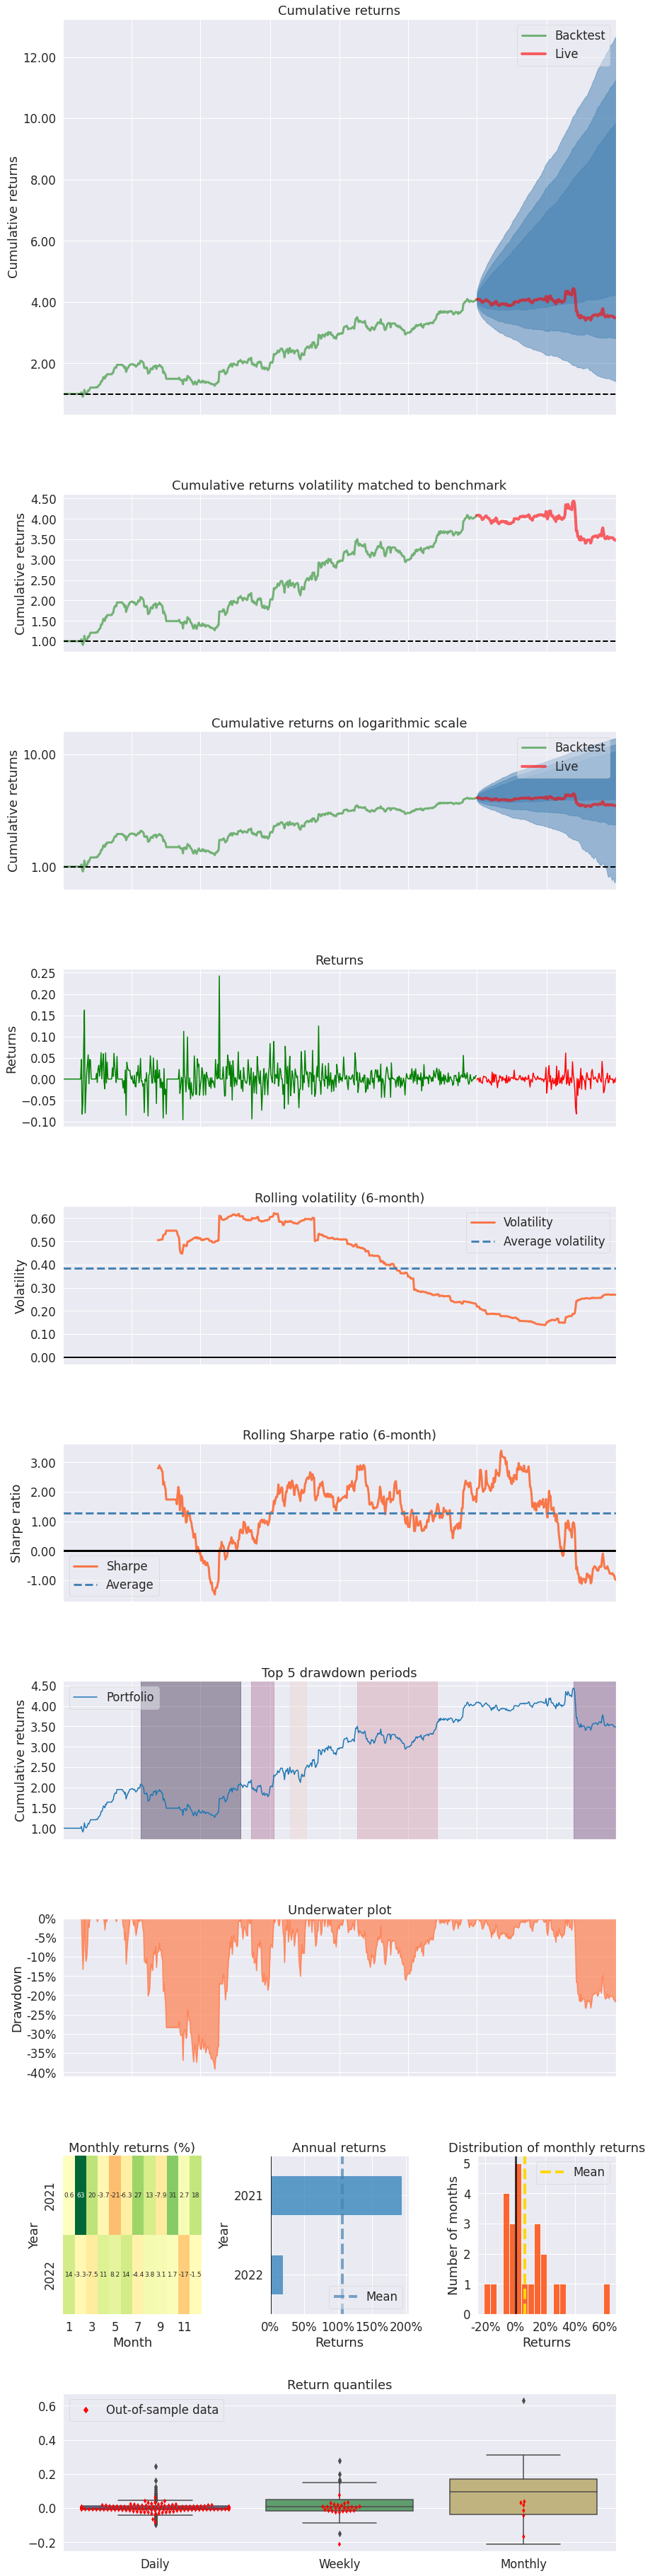

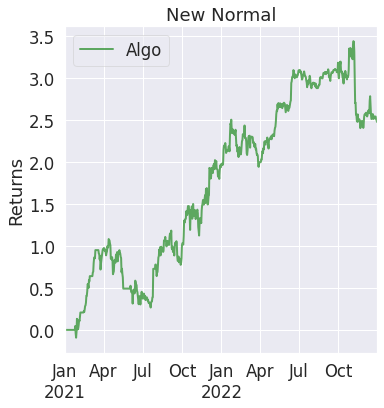

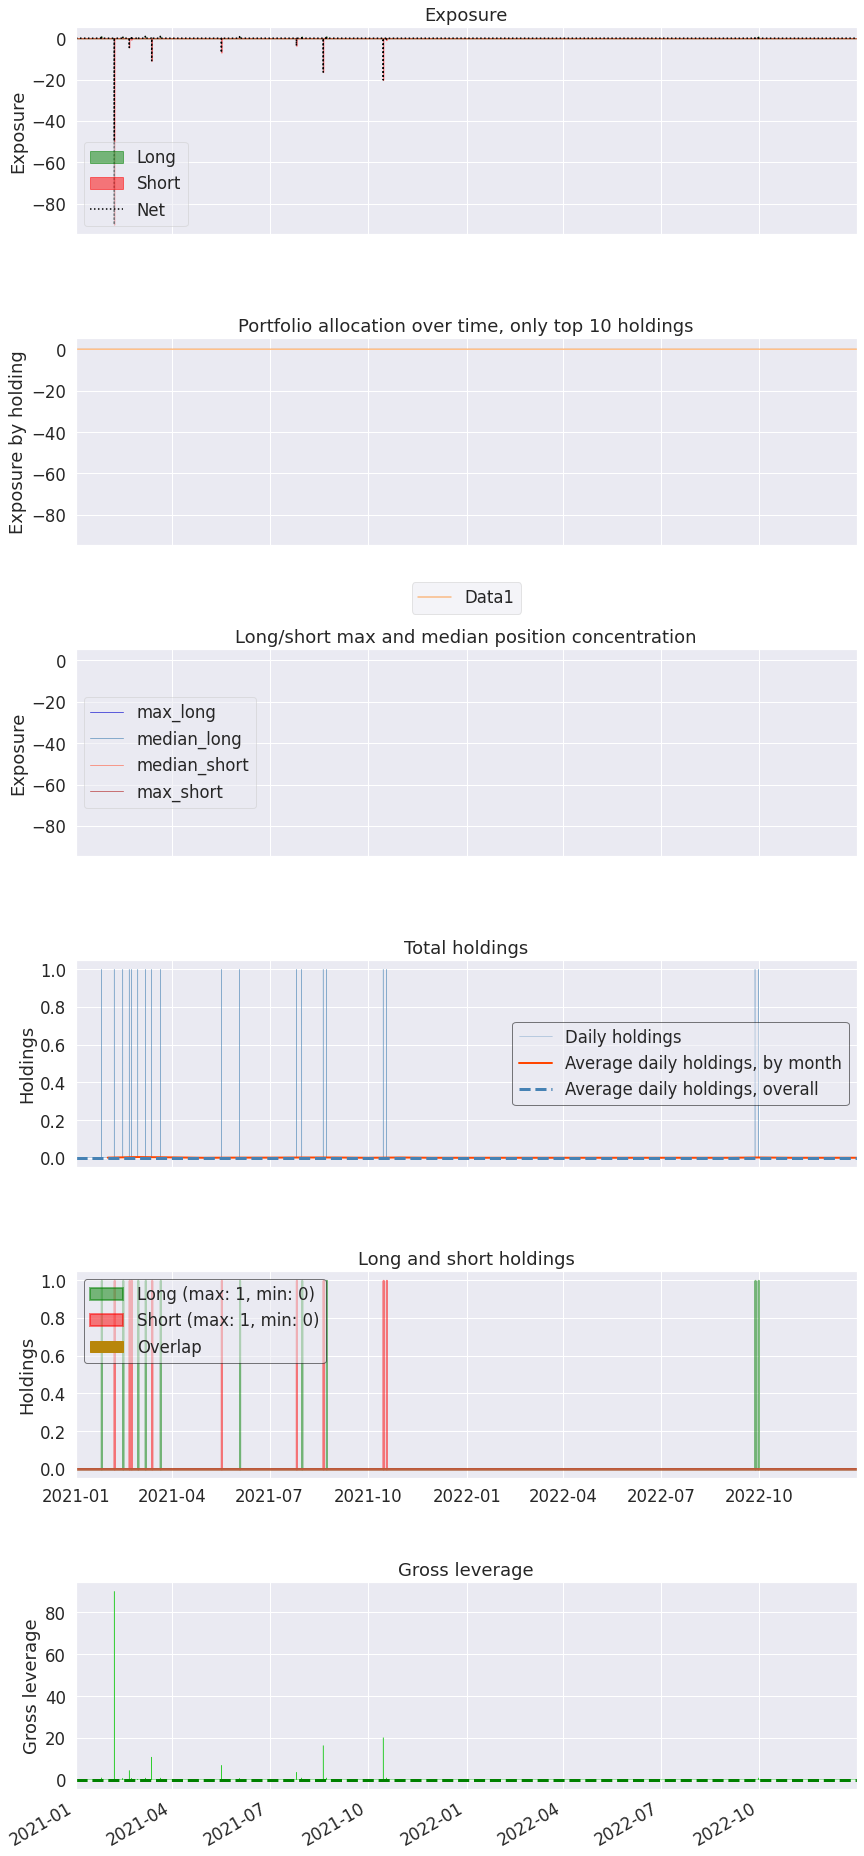

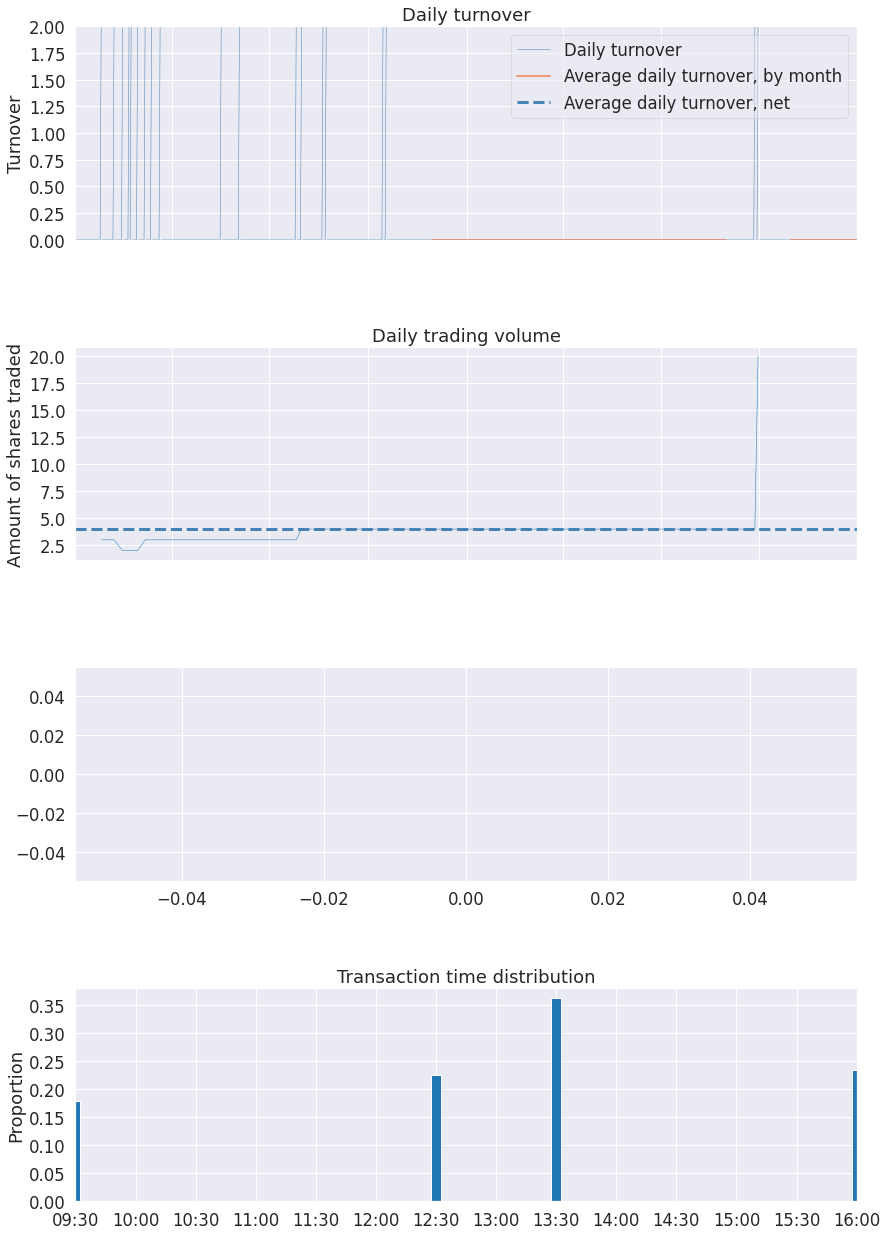

In [22]:
test_returns, test_positions,test_transactions = runstrat(['--use-pyfolio'],TestStrategy)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,40.72,2021-11-09,2022-10-02,NaT,NaN
1,21.74,2021-03-18,2021-06-08,2021-08-07,102
2,16.60,2021-01-14,2021-02-01,2021-02-08,18
3,11.90,2021-08-11,2021-08-31,2021-10-06,41
4,11.60,2021-02-20,2021-02-28,2021-03-07,10


Stress Events,mean,min,max
New Normal,0.06%,-9.70%,13.20%


Top 10 long positions of all time,max
sid,
,99.98%


Top 10 short positions of all time,max
sid,
,-209398.65%


Top 10 positions of all time,max
sid,
,209398.65%
Data1,0.00%


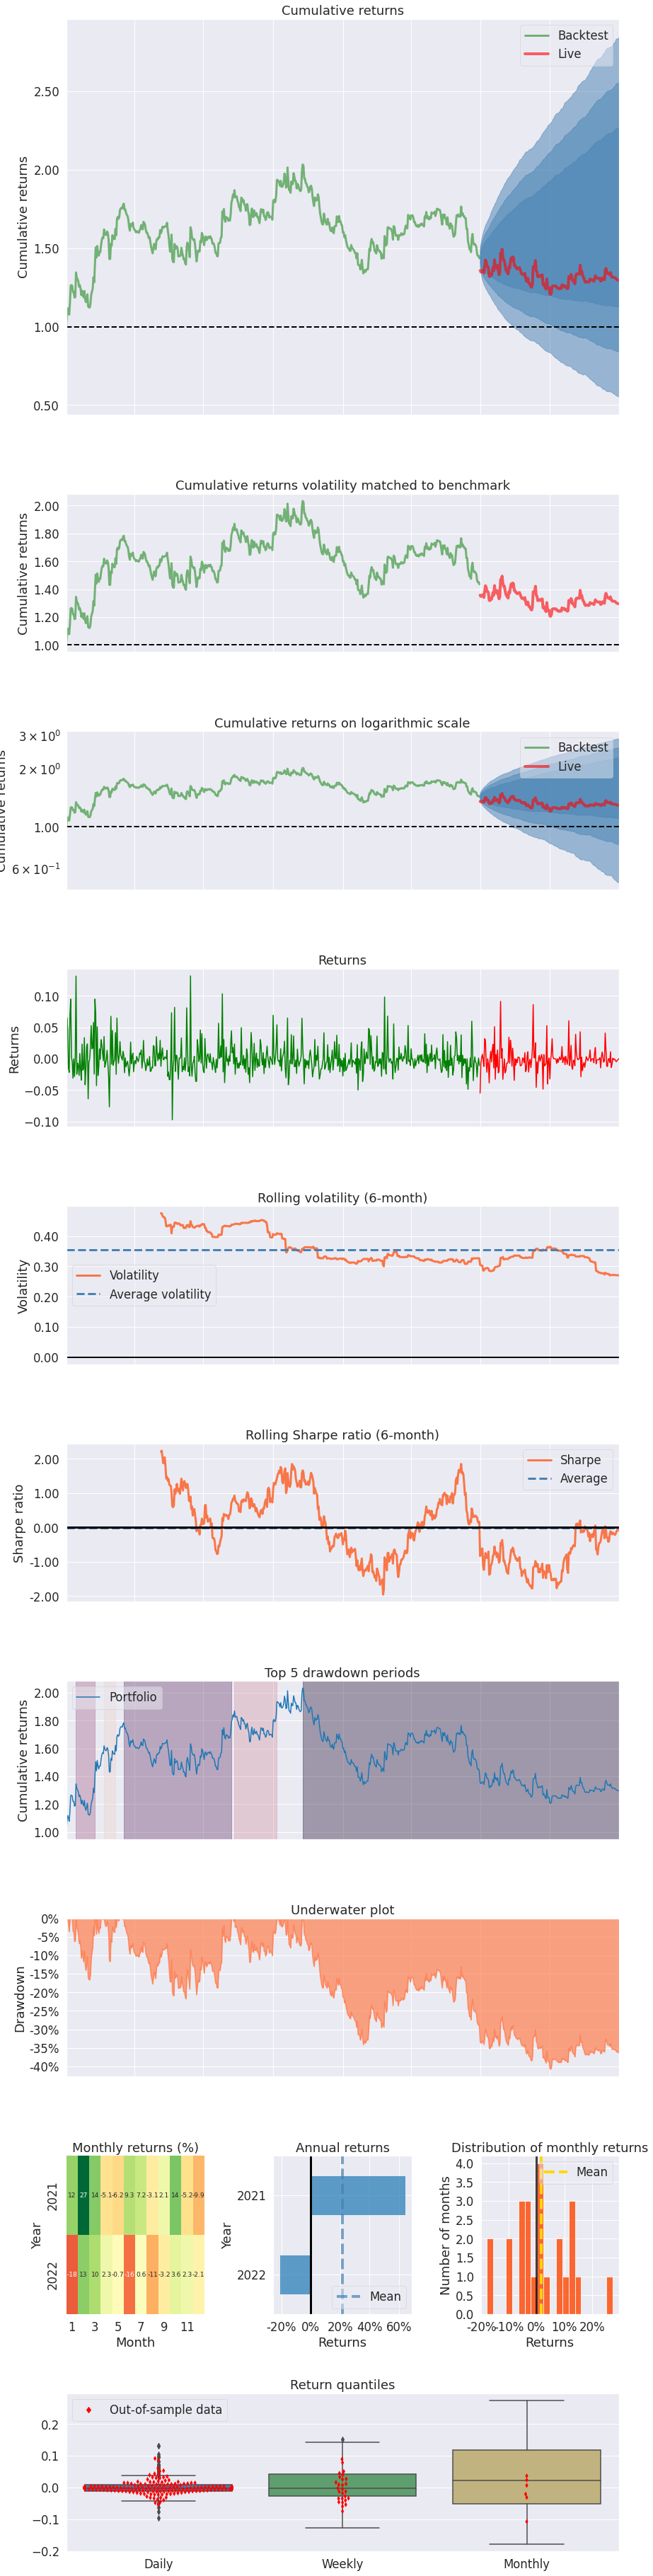

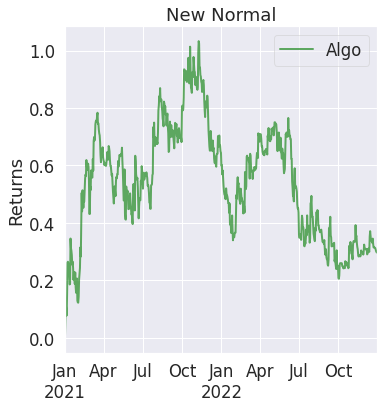

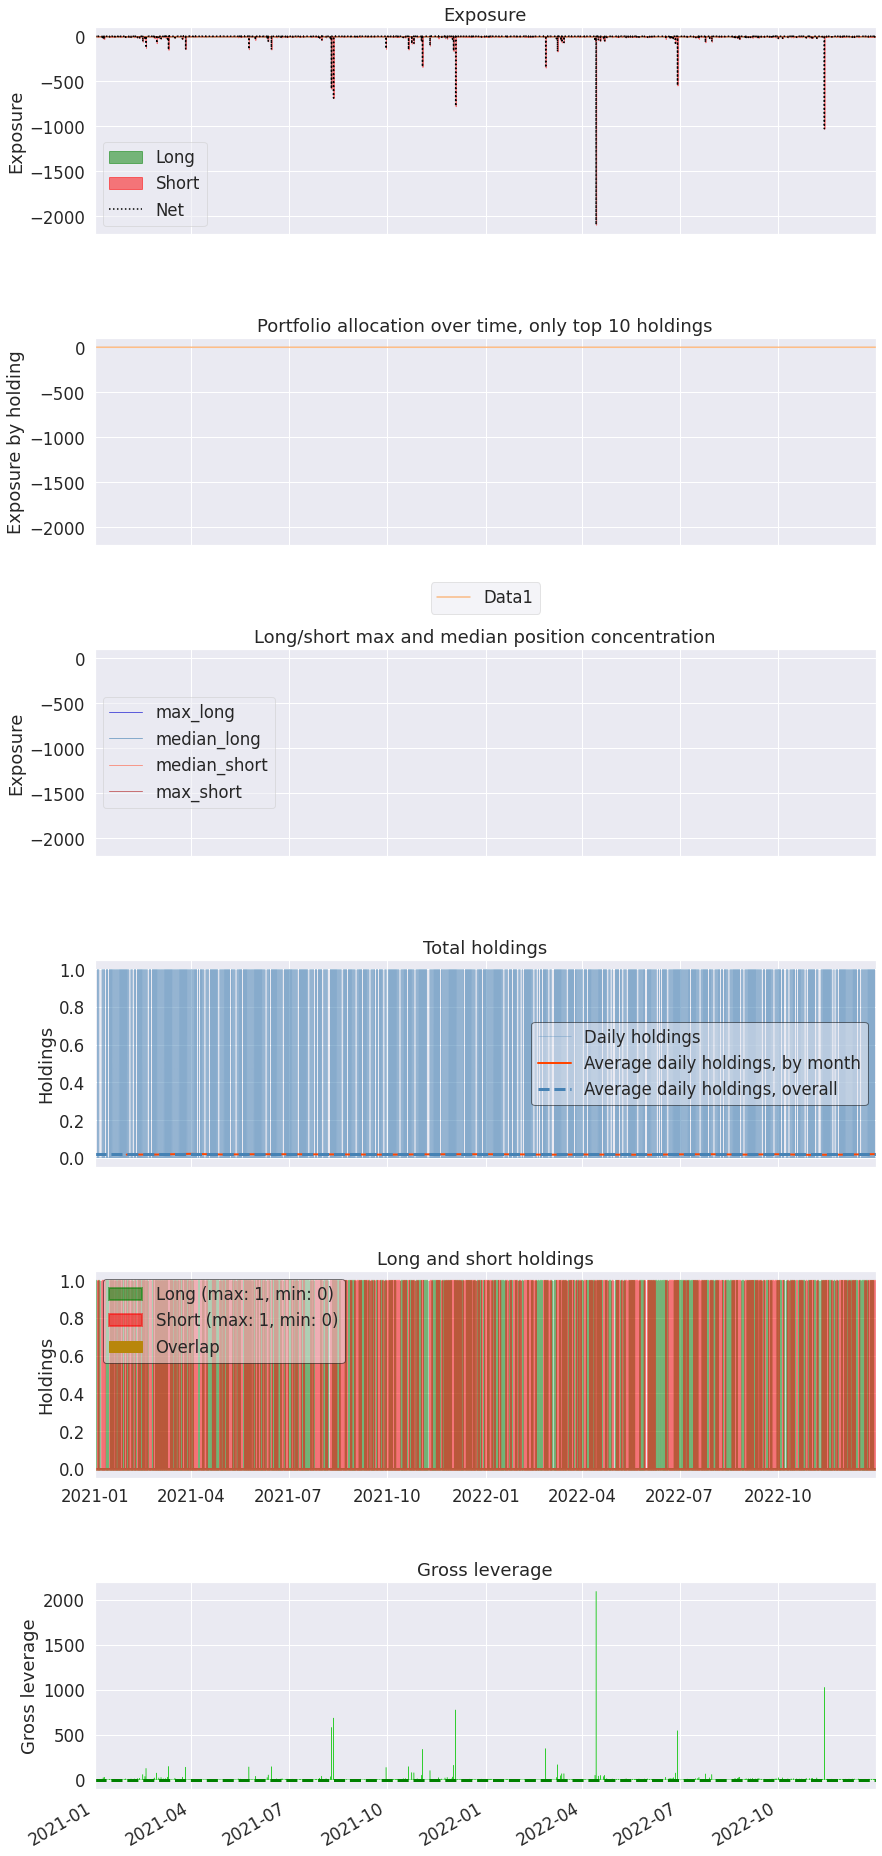

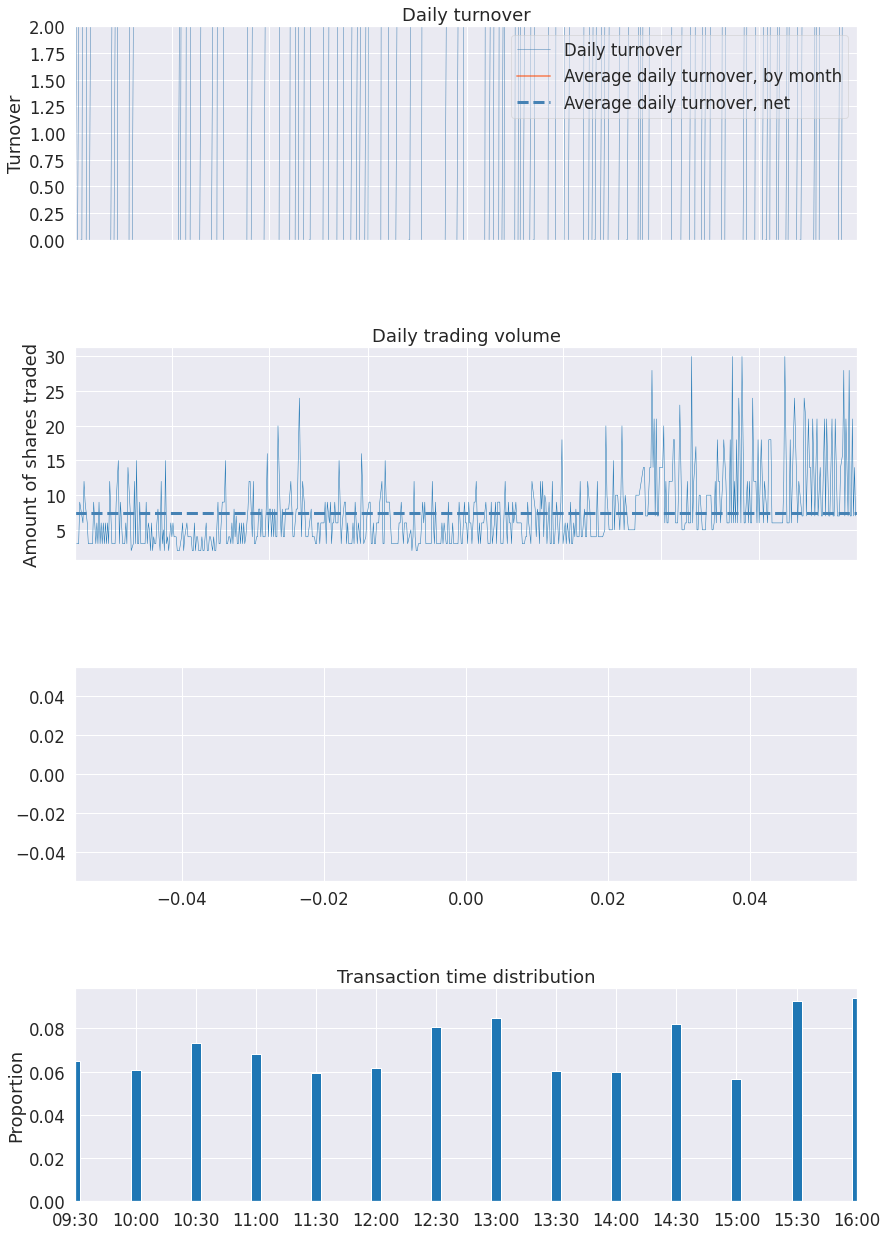

In [23]:
sma_returns, sma_positions,sma_transactions = runstrat(['--use-pyfolio'],SmaCross)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,49.83,2021-03-18,2021-07-20,2021-08-23,113
1,31.99,2022-06-14,2022-11-21,NaT,NaN
2,22.49,2021-01-14,2021-01-27,2021-01-29,12
3,21.56,2021-08-23,2021-09-28,2021-10-05,32
4,17.80,2021-01-29,2021-01-31,2021-02-05,6


Stress Events,mean,min,max
New Normal,0.27%,-14.39%,34.61%


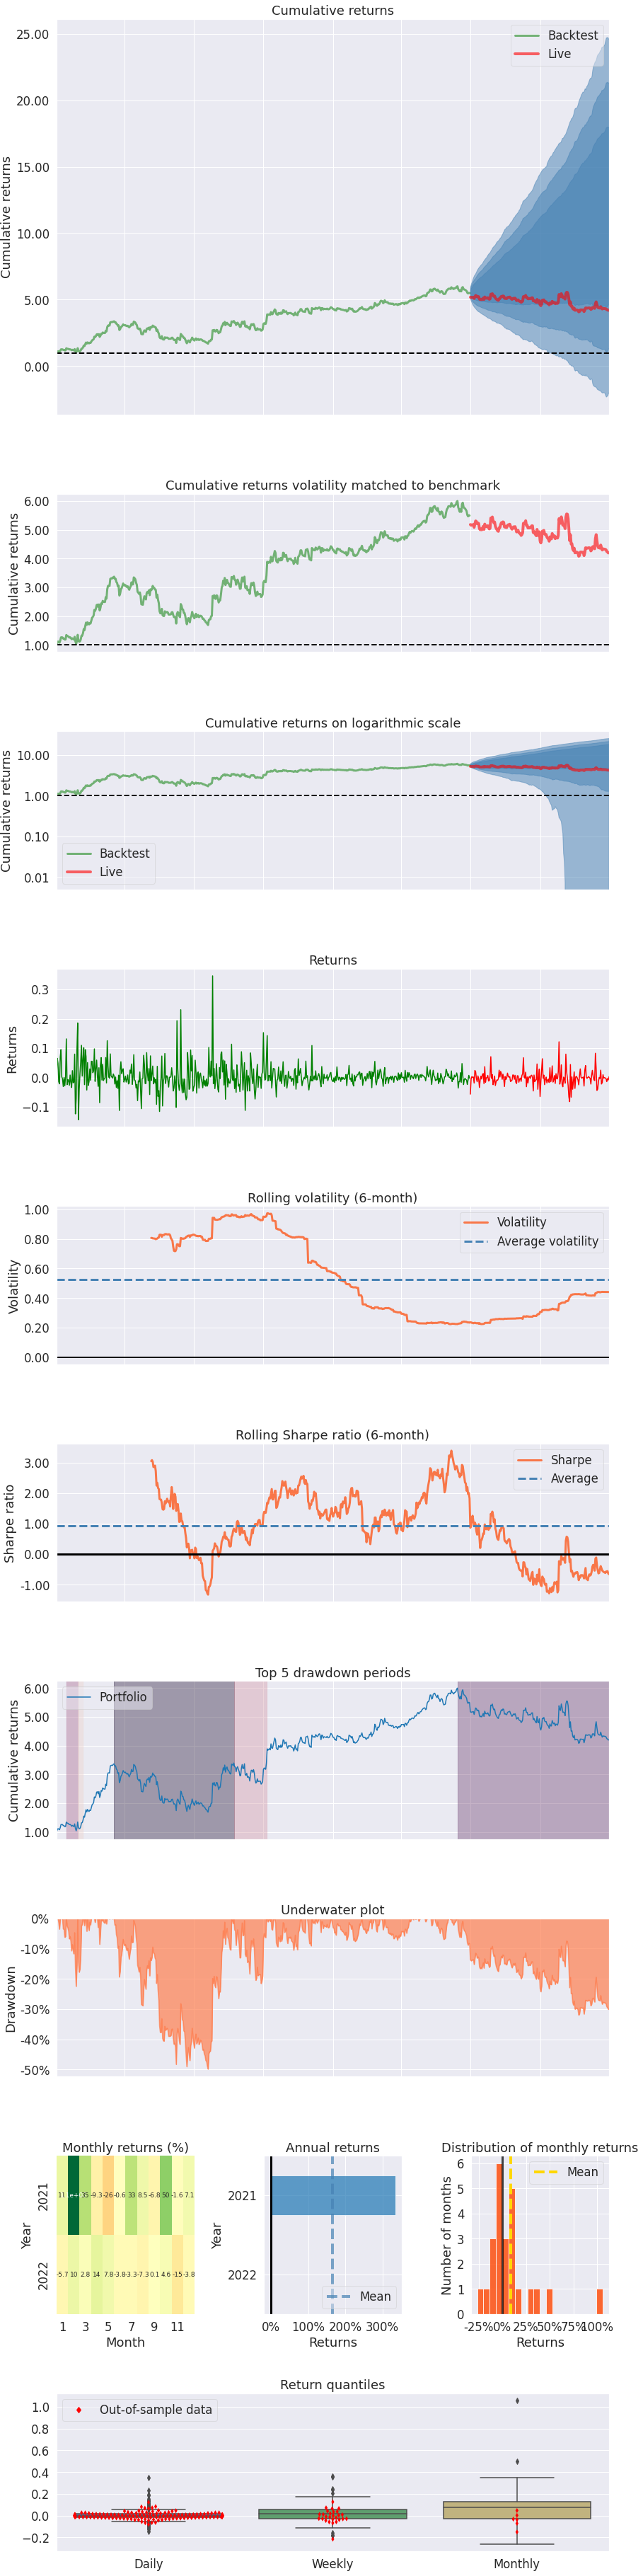

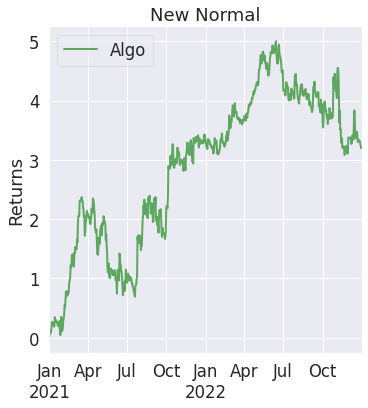

In [24]:
#策略合併後損益
import pyfolio as pf
pf.create_full_tear_sheet(
    test_returns+sma_returns,#可以加權重比如0.5*test_resturns + 1.5 *sma_returns
    
    live_start_date='2022-07-01',
    )

<IPython.core.display.Javascript object>

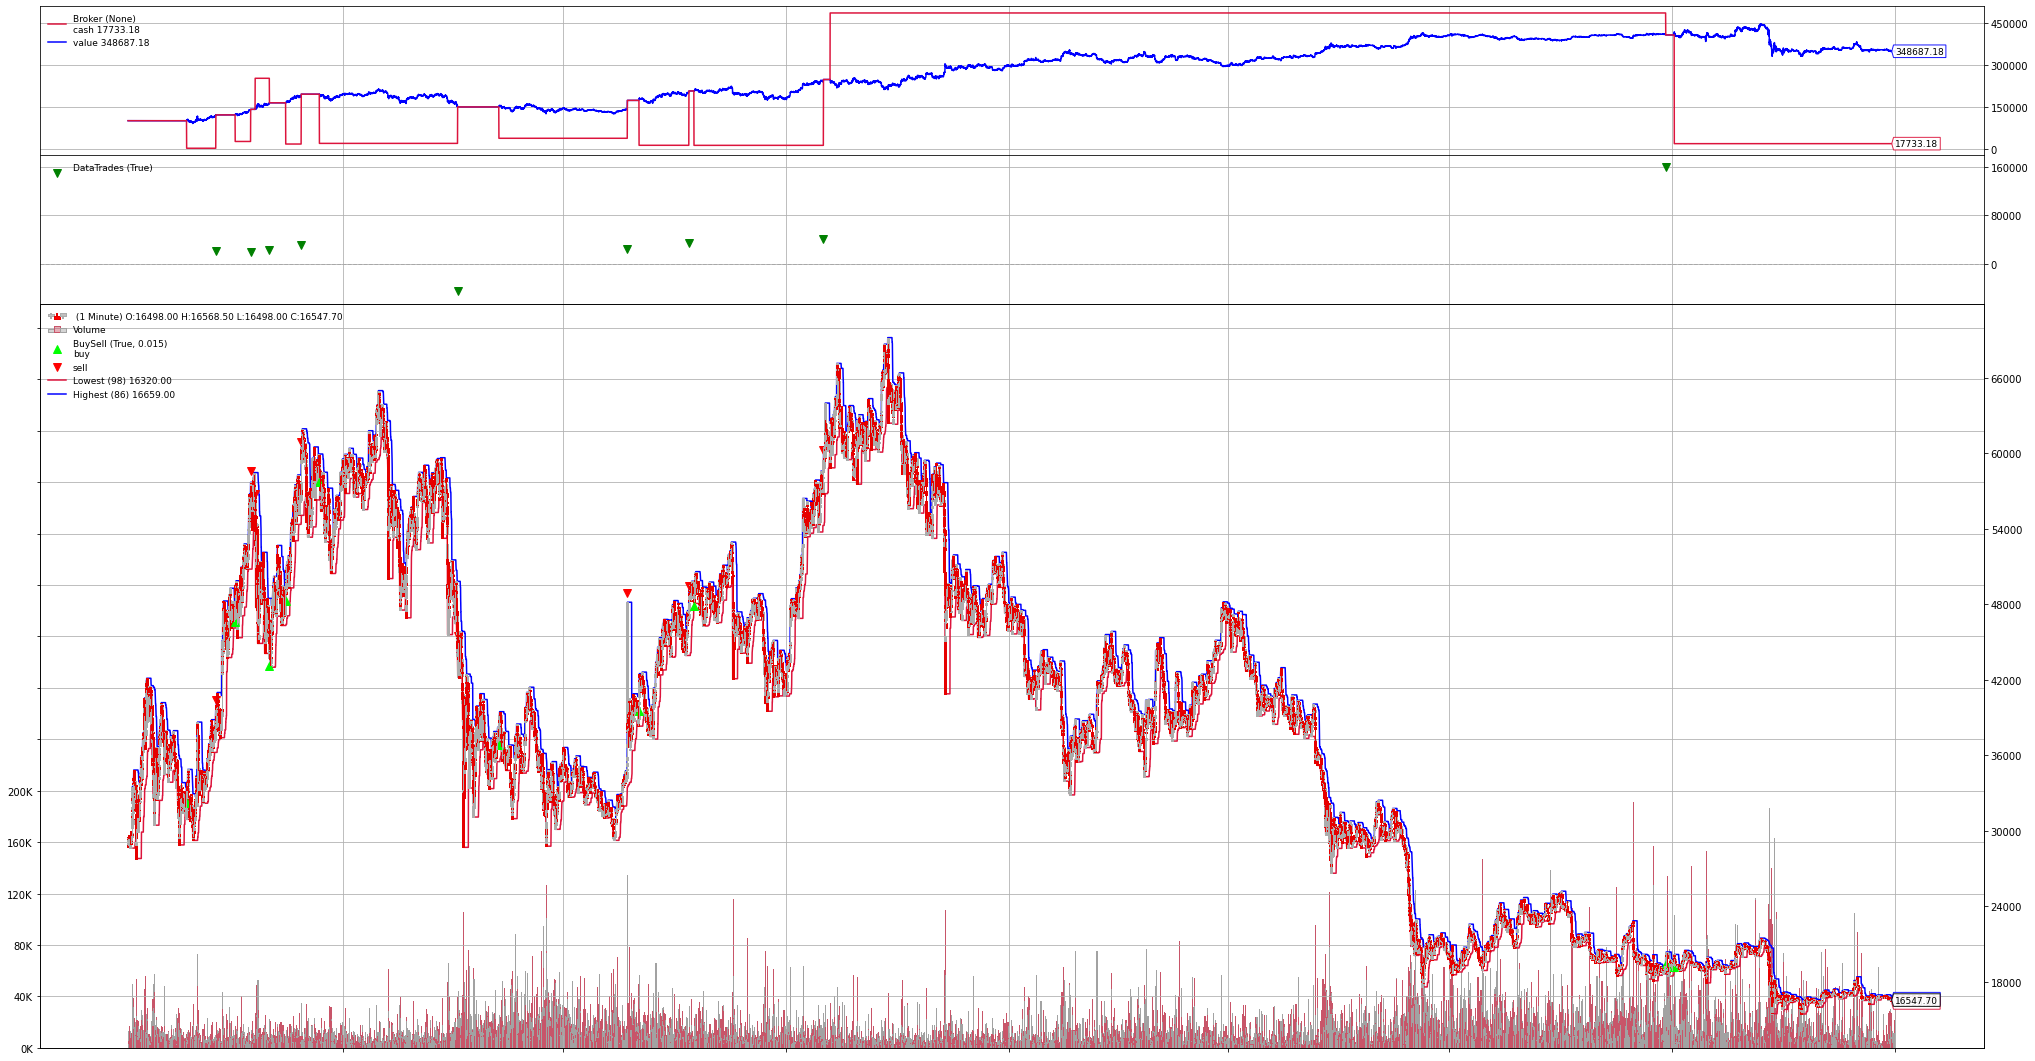

In [26]:
runstrat(['--plot','--plot-style','candle'],TestStrategy)